[1.5897933]


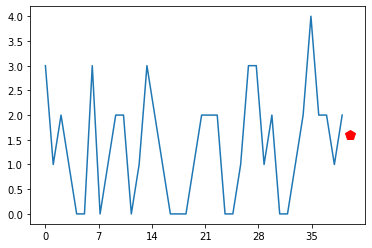

In [314]:
import pandas as pd
from numpy.random import randint
from random import random
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator
import matplotlib.pyplot as plt

# why did we choose ARIMA?
# -> data is stationary and seasonal

num_weeks = 4
peak_consume = 2.5
mu, sig = 0, 1 # mean and standard deviation of noise

num_days = 39
noise = np.random.normal(mu, sig, num_days)

x = np.linspace(0, num_days, num=num_days)
# center peaks at 0
# period = 7
# amplitude = peak_consume / 2
y1 = np.sin(x * ((2*np.pi) / 7) + (np.pi / 2)) * (peak_consume / 2) + peak_consume
y = y1 + noise - (sig / 2)

# discrete, positive values only
y = np.floor(y)
y[y<0] = 0

# --- PREDICTION --- #

model = ARIMA(y, order=(1,0,1))
model_fit = model.fit()

yhat = model_fit.predict(len(y), len(y))
print(yhat)

plt.Figure(figsize=(2, 8), dpi=100)
plt.xticks(np.arange(0, x[-1] + 1, 7)) # week interval x-axis
plt.plot(x, y)
plt.plot(x[-1] + 1, yhat, 'rp', markersize=10)